這次主要的應用為透過Hull-White預測未來的短期利率，並將此利率帶入集合布朗運動中，以此求出選擇權的未來價格，最後取期望值並已無風險利率折回，已得出本期選擇權價格，而這次的應用主要透過quantlib套件來輔助我們的運算，也讓我們更認識quantlib的操作。

In [ ]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np

sigma = 0.1
a = 0.1992
timestep = 12
length = 12 # in years
forward_rate = 0.03
day_count = ql.Thirty360()
todays_date = ql.Date(15, 1, 2015)
T = 1
N = 4000 # Path
dt = 1/12
S0 = 100
np.random.seed(1)
k=float(input("請輸入履約價"))
rf=0.03

ql.Settings.instance().evaluationDate = todays_date

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)


首先為套件的Import，要導入的套件有QuantLib、matplotlib.pyplot、numpy，導入後便開始設定後續需要的參數，之後就可以開始使用QuantLib的套件，求取出稍後會需要的參數。

In [ ]:
num_paths = 4000
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return arr

再來為generate_paths函式的定義，此函式主要功能為利用剛剛QuantLib求取出的參數，產出我們需要的短期利率，這裡將原本範例中的time列拿掉，只return出arr的部分，因此在呼叫這個函式之後，因為我們預設的num_paths為4000次，因此將會return出4000個array，每個array都包含了T/dt個短期利率的預測。

In [ ]:
mu=generate_paths(num_paths, timestep)
def genBrownPath (T, mu, sigma, S0, dt):
    
    n = round(T/dt)+1
    t = np.linspace(0, T , n)
    W = [0] + np.random.standard_normal(size = n) 
    W = np.cumsum(W)*np.sqrt(dt) # == standard brownian motion
    X = (mu-0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) # == geometric brownian motion
    plt.plot(t, S)
    return S[11]

接下來為genBrownPath函式的定義，此函式主要的功能為透過剛剛預測出的利率，計算出各期的股價預測值，在這邊因為只有return最後一期的股價，因此在return前先打上plt.plot的指令，如此之後呼叫函式時就能同時得到股價的預測走勢圖。

請輸入履約價110


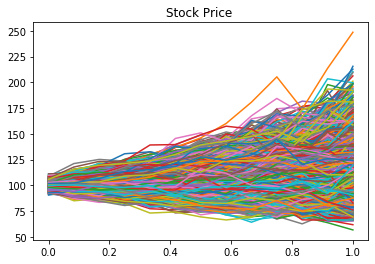

買權現價為9.517987232764858
賣權現價為5.7969159623669


In [8]:
s=[]
call=[]
put=[]
for i in range(4000):
    sf=genBrownPath(T, mu[i], sigma, S0, dt)
    s.append(sf)    
    c=max(0,sf-k)
    call.append(c)
    p=max(0,k-sf)
    put.append(p)
plt.title("Stock Price ")
plt.show()

meansc=sum(call)/num_paths
meansp=sum(put)/num_paths
callpv=(meansc*((1+rf*dt)**(-timestep)))
putpv=(meansp*((1+rf*dt)**(-timestep)))
print("買權現價為"+str(callpv))
print("賣權現價為"+str(putpv))



最後即為模擬的主要部分，先寫一個執行4000次的迴圈，再將剛剛建立好4000個利率預測array分別帶入函式中，並append每一次函式return的值，也就是每一次模擬的最後一期股價，於是我們便能用這4000千筆的末期股價來計算買賣權的價格，並分別取期望值，最後再透過無風險利率折現回第0期，此即為我們要求的選擇權現價。